In [2]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 1. PATH SETUP (matches your folder layout)
# Your notebook is in: project/notebooks/  So go UP ONE LEVEL to reach the project root
# In computer-speak, .. means "go up one level." It refers to the parent folder of wherever your script or notebook is currently running.
#.resolve() forces Python to look at the actual address on your hard drive. It turns a relative path (like "one floor up") 
# into an Absolute Path (like C:\Users\glori\Documents\...).
BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data" / "raw"

# A dictionary mapping each split name to its folder path. Using a dict instead of separate variables makes it easy to loop over later.
splits = {
    "train": DATA_DIR / "train",
    "validate": DATA_DIR / "validate",
    "test": DATA_DIR / "test"
}

# classes drives everything — the counting, totalling, and melting all reference it. rows will collect one dictionary per split, later turned into a DataFrame.
classes = ["edible", "poisonous"]
# a list of dictionaries. Each dictionary looked like {"split": "train", "edible": 1117, ...}. At this point, it’s just a long, messy list of text and numbers in Python's memory
rows = []

for split, dir_path in splits.items():
    # Starts a new dictionary for this split. After the inner loop it will look like:
    # python{"split": "train", "edible": 240, "poisonous": 180, "total": 420}
    row = {"split": split}
    
    # .glob("*") returns a generator of Path objects, one for each file. Example output (conceptually): data/raw/train/edible/Ganoderma_lucidum_000020_1.jpg
    # sum(1 for ...) → counts the matches by adding 1 for each valid file (more memory efficient than building a full list with len([...]))
    for cls in classes:
        valid_extensions = {".jpg", ".jpeg", ".png"}
        row[cls] = sum(1 for f in (dir_path / cls).glob("*") if f.suffix.lower() in valid_extensions)
        # So after the inner loop, row looks like:
        # python{"split": "train", "edible": 240, "poisonous": 180}

    # Adds up all class counts. Using classes here means if you add a third class, the total still works automatically.
    row["total"] = sum(row[c] for c in classes)
    # Adds the completed row dict to the list
    rows.append(row)

# a constructor from the Pandas library. It takes that list rows and automatically organizes it into a 2D grid (rows and columns).
df = pd.DataFrame(rows)
# When you type the name of a variable as the very last line in a code cell (especially in Jupyter Notebooks or VS Code), it tells Python to display or print the contents of that variable.
# Without this line, the DataFrame would be created silently in the background.
df

,split,edible,poisonous,total
0,train,1200,1056,2256
1,validate,150,132,282
2,test,150,132,282


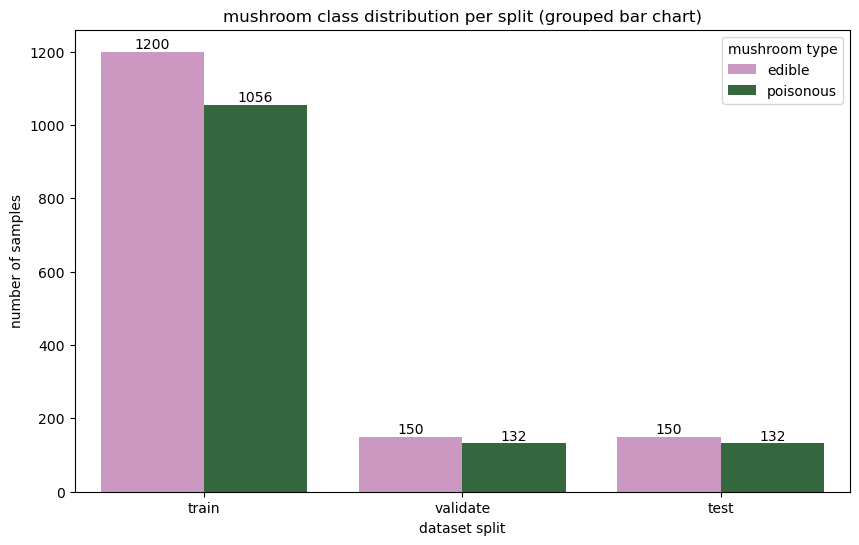

In [12]:
#BEFORE melt (wide)
#AFTER melt (long):
#split     mushroom type   number of samples
#train     edible          1200
#train     poisonous       1056
# standard pandas melt parameters/parameter names of the .melt() function. always called this.
# your DataFrame does NOT need to have columns with these names. they are just the arguments that tell pandas how to reshape your data.
df_melted = df.melt(
    id_vars='split', # Keep `split` column as-is. columns that should stay as they are. These columns are identifiers. 
    value_vars=classes, # columns that should be unpivoted into rows, turned into long format
    var_name='mushroom type', # The new column that holds the old column names
    value_name='number of samples' # The new column that holds the actual counts/values
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x='split', y='number of samples', hue='mushroom type', palette='cubehelix_r')

for container in ax.containers:
    ax.bar_label(container)

plt.legend(title="mushroom type")
plt.title('mushroom class distribution per split (grouped bar chart)')
plt.xlabel('dataset split')
plt.ylabel('number of samples')
plt.show()